## Predicting Adult Obesity Based on Lifestyle Factors
#### Fall 2025 Data Science Project
#### Stephen Wu, Isaac Berkower, Molly Panepento, Daniel Qian, Atul Iyengar

## Contributions
#### A: Project Idea - Everyone
#### B: Dataset Curation and Preprocessing - Molly
#### C: Data Exploration and Summary Statistics - Stephen, Isaac, Daniel, Atul
#### D: ML Algorithm Design/Development - Molly
#### E: ML Algorithm Training and Test Data Analysis - Molly, Stephen
#### F: Visualization, Result Analysis, Conclusion - Atul, Isaac
#### G: Final Tutorial Report Creation - Daniel, Isaac, Stephen

# Introduction

#### The escalating prevalence of obesity is a major public health concern, driving up risks for chronic diseases globally. Our project works to address this challenge by developing a machine learning classifier to predict an adult's probability of being obese or overweight based on key behavioral risk factors.

#### We employed the K-Nearest Neighbor (KNN) model to create classification model based on this data.

# Data Curation

Our data is from the CDC's "Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System" dataset, which
is publicly available through the CDC and includes annual, state-level health behavior related to physical activity, nutrition, overweight, and obesity among adults in the United States.

The BRFSS dataset contains a large number of variables, including:


*   Demographic information (age, income, sex, education, race/ethnicity)
*   Geographic information (state and location IDs)
*   Health behavior indicators (physical activity, frequency, fruit/vegetable consumption)
*   Health outcomes (overweight and obesity prevalence)
*   Data quality information (confidence limits, sample size, data source)

Each row represents a specific combination of state, demograpghic group, year, and survey questions with each value corresponding to a percentage or count depending on the survey question.

**Dataset Citation:**

Centers for Disease Control and Prevention. Nutrition, Physical Activity, and Obesity: Behavioral Risk Factor Surveillance System. CDC, 22 Oct. 2025, https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7


First, let's import all of the libraries we will need throughout our data analysis. We weill import some standard data science libraries including pandas, NumPy, sckikit-learn, seaborn, matplotlib, and more

In [9]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import statsmodels.stats.multicomp as smmc
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from IPython.display import HTML

To prepare the datatset for analysis, let's start by doing some preprocessing steps.

To begin, we will import the dataset into a pandas dataframe.

In [10]:
df = pd.read_csv('Nutrition,_Physical_Activity,_and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System_20251022.csv')

Many numeric fields are read as strings due to formatting inconsistencies. We will convert these columns into int values. This ensures calculations with the data all work correctly.

In [11]:
numeric_cols = ['YearStart', 'YearEnd', 'Data_Value', 'Data_Value_Alt', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Sample_Size']
for col in numeric_cols:
  if col in df.columns:
    df[col] = df[col].apply(pd.to_numeric, errors='coerce')

Some of the column names contained spaces and inconsistent formatting, let's clean them into snake case to make them easier to reference and utilize.

In [12]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('__', '_')

The GeoLocatin column includes both the latitude and longitude for coordinates. To make geographic analysis and plotting easier, let's separate the two.

In [13]:
df['GeoLocation'] = df['GeoLocation'].str.strip('()').str.replace("(", "").str.replace(")", "")
df[['Latitude', 'Longitude']] = df['GeoLocation'].str.split(',', expand=True)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
df.drop(columns=['GeoLocation'], inplace=True)

Finally, let's ensure all of these transformations worked properly and that the final structure of the dataframe is ready for data analysis!

In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106260 entries, 0 to 106259
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   YearStart                   106260 non-null  int64  
 1   YearEnd                     106260 non-null  int64  
 2   LocationAbbr                106260 non-null  object 
 3   LocationDesc                106260 non-null  object 
 4   Datasource                  106260 non-null  object 
 5   Class                       106260 non-null  object 
 6   Topic                       106260 non-null  object 
 7   Question                    106260 non-null  object 
 8   Data_Value_Unit             0 non-null       float64
 9   Data_Value_Type             106260 non-null  object 
 10  Data_Value                  93505 non-null   float64
 11  Data_Value_Alt              93505 non-null   float64
 12  Data_Value_Footnote_Symbol  12755 non-null   object 
 13  Data_Value_Foo

# Exploratory Data Analysis

#### Let's start by examining how different demographic chracteristics related to obesity, including region, sex, and income.

## TEST 1: Outlier Analysis by Region

#### In our first analysis of the dataset, we will visually represent the datset as bar and scatter plots to compare obesity rates among different regions and identify outliers via visual inspection. We took the average for each region's obesity rates and plotted them on a bar and scatter plot.

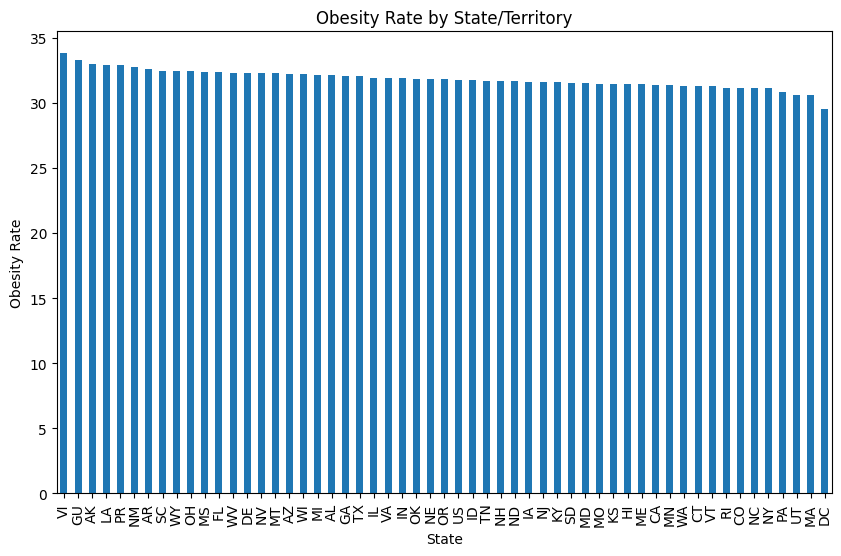

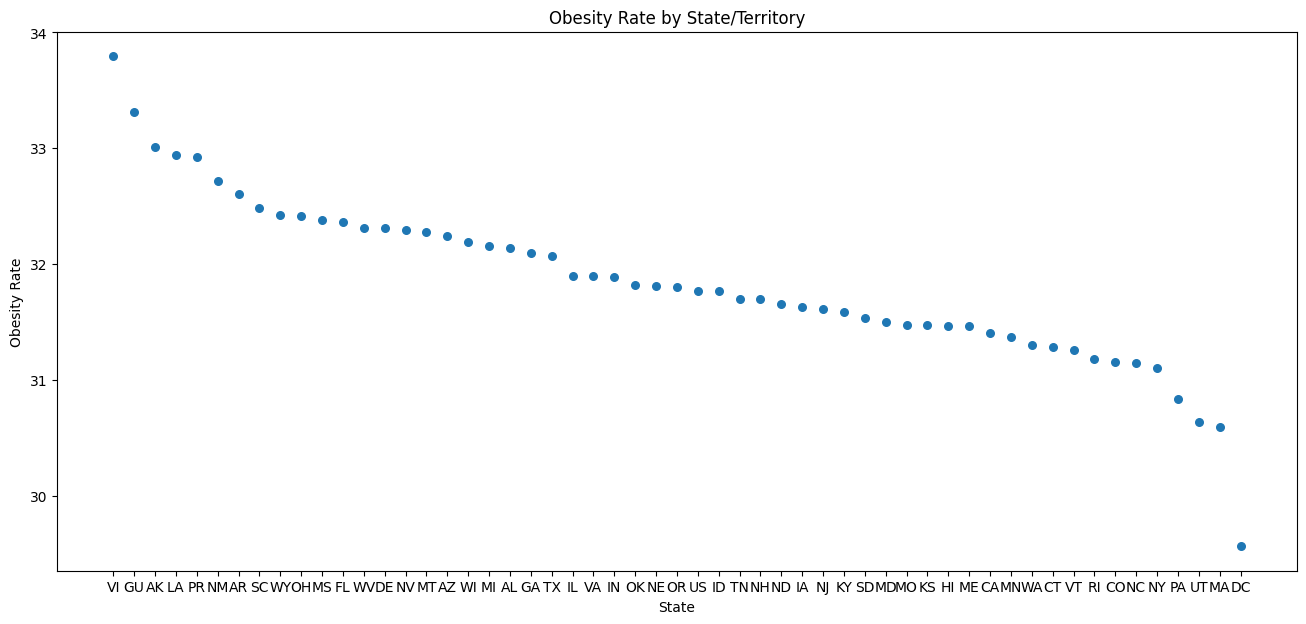

In [15]:
# find the average obesity rate for each state, and among those identify outlier states (outlying % of obesity)
df_total = df[df['Total'] == 'Total']
state_groups = df_total.groupby('LocationAbbr')
state_obesity_rates = state_groups['Data_Value'].mean()
state_obesity_rates.sort_values(ascending=False, inplace=True)

# bar chart for all states with percentage
state_obesity_rates.plot.bar(width=0.5, figsize=(10, 6))
plt.xlabel('State')
plt.ylabel('Obesity Rate')
plt.title('Obesity Rate by State/Territory')
plt.show()

# scatter plot to idetify outliers
plt.figure(figsize=(16, 7))
plt.scatter(state_obesity_rates.index, state_obesity_rates.values, s=30)
plt.xlabel('State')
plt.ylabel('Obesity Rate')
plt.title('Obesity Rate by State/Territory')
plt.show()

## Test 1 Conclusion:

#### Our conclusion from the above bar and scatter plots are that the Virgin Islands (VI) represents the upper outlier in obesity rate by state/territory, having an obesity rate of nearly 35%, almost 1.5% higher than the next highest territory of Guam. The lower outlier is the region of Washington, D.C. (DC), which has an obesity rate of below 30%, nearly a full 1% below the next lowest obesity rate. We can see this directly in the scatter plot above where VI and DC are significantly above and below the line of best fit, thus they can be identified as outliers by visual inspection.

## TEST 2: Obesity vs. Sex

#### In this test we will compare obesity rates between male and female adults. For each region the BRFSS provides stratified estimates Male/Female and an overall Total row. Because the dataset covers 2011–2023 and each region reports sex-specific estimates yearly, we add the sex-specific estimates and average them by region. This gives one male and one female mean obesity percentage per region. We then perform a paired statistical test comparing males and females across the same regions. Finally, we will visualize the data with a plot.

In [16]:
# Create dataframe susbet with relevant columns
df_obesity = df[
    (df['Topic'].str.contains('Obesity / Weight Status', case=False, na=False)) &
    (df['Question'].str.contains('Percent of adults aged 18 years and older who have obesity', case=False, na=False))
    ].copy()

# Display info about the new dataframe
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20020 entries, 0 to 97019
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   20020 non-null  int64  
 1   YearEnd                     20020 non-null  int64  
 2   LocationAbbr                20020 non-null  object 
 3   LocationDesc                20020 non-null  object 
 4   Datasource                  20020 non-null  object 
 5   Class                       20020 non-null  object 
 6   Topic                       20020 non-null  object 
 7   Question                    20020 non-null  object 
 8   Data_Value_Unit             0 non-null      float64
 9   Data_Value_Type             20020 non-null  object 
 10  Data_Value                  17694 non-null  float64
 11  Data_Value_Alt              17694 non-null  float64
 12  Data_Value_Footnote_Symbol  2326 non-null   object 
 13  Data_Value_Footnote         2326 non

#### Now we can reduce this dataframe to the rows where the stratification is done by Sex. This will allow us to see just the data reported by Males and Females.

In [17]:
# Keep only rows that are stratified by Sex
df_sex_rows = df_obesity[df_obesity['StratificationCategory1'] == 'Sex'].copy()

# ensure stratification contains Male/Female
df_sex_rows = df_sex_rows[df_sex_rows['Stratification1'].isin(['Male','Female'])]

# drop rows missing Data_Value
df_sex_rows = df_sex_rows[df_sex_rows['Data_Value'].notna()]

df_sex_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1394 entries, 16 to 97014
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   1394 non-null   int64  
 1   YearEnd                     1394 non-null   int64  
 2   LocationAbbr                1394 non-null   object 
 3   LocationDesc                1394 non-null   object 
 4   Datasource                  1394 non-null   object 
 5   Class                       1394 non-null   object 
 6   Topic                       1394 non-null   object 
 7   Question                    1394 non-null   object 
 8   Data_Value_Unit             0 non-null      float64
 9   Data_Value_Type             1394 non-null   object 
 10  Data_Value                  1394 non-null   float64
 11  Data_Value_Alt              1394 non-null   float64
 12  Data_Value_Footnote_Symbol  0 non-null      object 
 13  Data_Value_Footnote         0 non-nu

#### Multiple years per region create repeated/overlapping data. To maintain independence and to produce one male and one female value per region, we will average across years for each region and sex. This gives a single paired observation per region.

In [18]:
# Compute region-level mean Data_Value by sex
region_avg_df = (df_sex_rows.groupby(['LocationDesc', 'Stratification1'], as_index=False)['Data_Value'].mean())

# Split into male and female tables
male_df = region_avg_df[region_avg_df['Stratification1'] == 'Male'][['LocationDesc', 'Data_Value']]
female_df = region_avg_df[region_avg_df['Stratification1'] == 'Female'][['LocationDesc', 'Data_Value']]

# Rename columns
male_df = male_df.rename(columns={'Data_Value': 'Male_Mean'})
female_df = female_df.rename(columns={'Data_Value': 'Female_Mean'})

# Merge male and female data (using inner join)
region_avg_df = pd.merge(male_df, female_df, on='LocationDesc', how='inner')

# Compute and print summary statistics for numeric columns only
summary_stats = region_avg_df[['Male_Mean', 'Female_Mean']].agg(['count', 'mean', 'std', 'median', 'min', 'max']).T
print(summary_stats)

             count       mean       std     median        min        max
Male_Mean     55.0  30.565642  3.421949  30.584615  19.376923  37.907692
Female_Mean   55.0  30.963792  4.212451  30.784615  21.653846  40.450000


#### The 0.4% difference between Male and Female Average Obesity Values indicate very similar obesity rates across adults in the USA on average. The female standard deviation being almost 0.8 greater indicates more geographic variation in obesity rates among females compared to males. The incredibly similar median values reinforces the idea that the central value is similar across sexes. Despite the ranges being nearly identical, the nationwide female minimum and maximum obesity means are greater than those of the males, meaning some regions may have particularly high obesity rates among females.

#### Now, we can perform a hypothesis test. However, we need to check if we can assume normality in our data by performing a Shapiro-Wilk test, which will give us a p-value based on the distribution of the data. If the statistic returned is greater than an alpha level of 0.05 (α = 0.05), we can assume normality and run a normal paired-sample t-test. Otherwise, we must use the Wilcoxon Signed Rank Test, which is a non-parametric test which does not assume normality and works around outliers or extraneous values.

In [19]:
region_avg_df['Diff'] = region_avg_df['Male_Mean'] - region_avg_df['Female_Mean']

_, p_shapiro = stats.shapiro(region_avg_df['Diff'])
print(f"Shapiro-Wilk p-value: p={p_shapiro:4f}")

Shapiro-Wilk p-value: p=0.000001


#### Since we have an incredibly low p-value which is obviously less than 0.05 (α = 0.05), we are not working with a normally distributed dataset. Hence, we will perform a Wilcoxon Signed Rank Test.

#### Hypotheses

#### Null Hypothesis (H₀): There is no significant difference in obesity rates between men and women. (μ_male​=μ_female​)

#### Alternative Hypothesis (Hₐ): There is a significant difference in obesity rates between men and women. (μ_male​≠μ_female​)

#### We will use a Wilcoxon Signed Rank Test since the data is not normally distributed but Male and Female groups are independent and their values our continuous. We will use an alpha level of 0.05 (α = 0.05)

In [20]:
_, p_val = stats.wilcoxon(region_avg_df['Male_Mean'], region_avg_df['Female_Mean'])
print(f"Wilcoxon Test Results: p-value = {p_val:.4f}")

Wilcoxon Test Results: p-value = 0.8276


#### We can now use a scatter plot to see the differences between male and female obesity percentages.

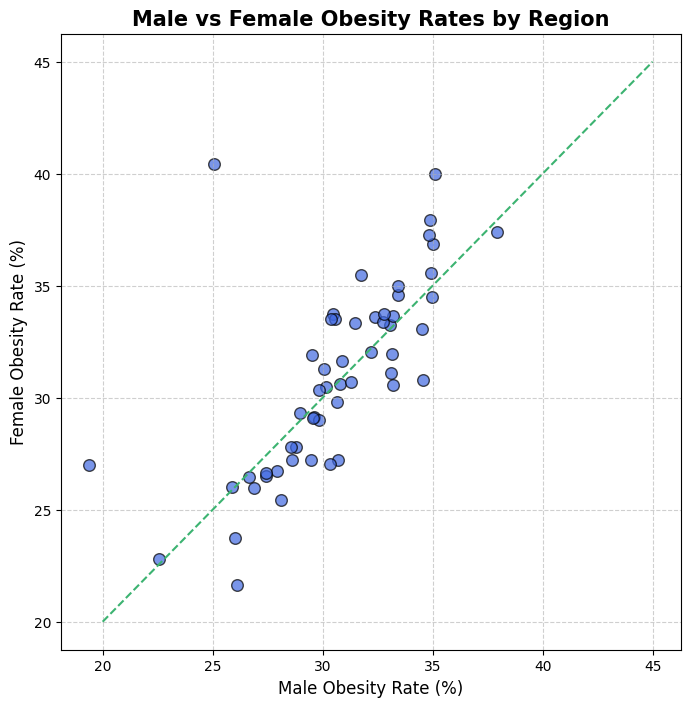

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(region_avg_df['Male_Mean'], region_avg_df['Female_Mean'],
            color='royalblue', edgecolor='black', alpha=0.7, s=70)
plt.plot([20, 45], [20, 45], linestyle='--', color='mediumseagreen', linewidth=1.5)  # y = x line
plt.title('Male vs Female Obesity Rates by Region', fontsize=15, weight='bold')
plt.xlabel('Male Obesity Rate (%)', fontsize=12)
plt.ylabel('Female Obesity Rate (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Since the plotted points are very close to the y=x line, we can substantiate the result we got from the Hypothesis Test. Male and Female obesity rates do not seem to differ a lot, and seem highly consistent with each other. This supports our choice to fail to reject the null hypothesis, meaning there is no statistically signifcant difference between obesity rates between both groups. Also, the few very-high Female Obesity Rate values above or around the 40% mark explain the greater standard deviation and range values observed earlier when looking at the summary statistics.

## Test 2 Conclusion

#### A Wilcoxon signed-rank test was performed to compare the mean obesity rates between males and females across U.S. regions. The test yielded a p-value of 0.8276, which is greater than the alpha value/significance level α = 0.05. Therefore, we fail to reject the null hypothesis, indicating no statistically significant difference in obesity proportions/rates between men and women.

#### Descriptive statistics showed that both groups had nearly identical average obesity rates, and the visualization confirmed this observation, with regional values for males and females following closely with the y=x line.

#### At the regional level, obesity rates among adult males and females in the United States are very similar, suggesting that sex alone is not a strong factor for obesity rates in this dataset.

## Test 3: Obesity vs. Income (Correlation)

#### For this section, we examine whether adult obesity rates differ significantly across income categories in the CDC BRFSS dataset. Income is a key socioeconomic factor often linked to health outcomes and we want to know:

#### Do U.S. adults in lower income brackets exhibit higher average obesity rates than those in higher income brackets?

#### To answer this, we ran a one-way ANOVA to test whether at least one income group’s mean obesity rate differs, and a Tukey HSD post-hoc test to identify which income groups differ.

#### Hypothesis

#### Null Hypothesis (H₀): All income groups have the same mean obesity rate.

#### Alternative Hypothesis (Hₐ): At least one group mean differs.

In [22]:
# Drop missing data
df_income = df[['Income', 'Data_Value']].dropna()

# Drop "Data not reported" column
df_income_clean = df[df['Income'] != 'Data not reported'].dropna(subset=['Data_Value'])

# Group obesity rates by income category
groups = [group['Data_Value'].values for name, group in df_income_clean.groupby('Income')]

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA test p-value: {p_value:.6g}")

ANOVA test p-value: 0.00521002


## Hypothesis Test Conclusion
#### The one-way ANOVA test found a statistically significant effect of income on obesity rates (p-value = 0.0052).
#### Because the p-value is below the 0.05 significance threshold, we reject the null hypothesis that all income groups have equal mean obesity rates.
#### This indicates that at least one income group differs significantly from the others, prompting further analysis using a Tukey HSD post-hoc test to identify which groups differ.

## Post Hoc Analysis
####The "Data not reported" category was excluded from the post-hoc analysis because it represents missing or suppressed responses rather than a true income group. Including it could bias the results, as its obesity rates were unrealistically low and not comparable to the actual income brackets.

In [23]:
tukey = smmc.pairwise_tukeyhsd(
    endog=df_income['Data_Value'],    # numeric dependent variable
    groups=df_income['Income'],       # categorical independent variable
    alpha=0.05                        # significance level
)

tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

mask = ~(
    tukey_df['group1'].str.contains('Data not reported')
    | tukey_df['group2'].str.contains('Data not reported')
)

tukey_filtered = tukey_df[mask]

tukey_filtered

,group1,group2,meandiff,p-adj,lower,upper,reject
0,"$15,000 - $24,999","$25,000 - $34,999",-0.1739,0.9892,-0.8557,0.5080,False
1,"$15,000 - $24,999","$35,000 - $49,999",-0.2262,0.9588,-0.9081,0.4557,False
2,"$15,000 - $24,999","$50,000 - $74,999",-0.4086,0.5709,-1.0907,0.2735,False
3,"$15,000 - $24,999","$75,000 or greater",-0.7868,0.0119,-1.4687,-0.1050,True
5,"$15,000 - $24,999","Less than $15,000",0.0150,1.0000,-0.6669,0.6969,False
6,"$25,000 - $34,999","$35,000 - $49,999",-0.0524,1.0000,-0.7342,0.6295,False
7,"$25,000 - $34,999","$50,000 - $74,999",-0.2348,0.9508,-0.9169,0.4473,False
8,"$25,000 - $34,999","$75,000 or greater",-0.6130,0.1112,-1.2948,0.0689,False
10,"$25,000 - $34,999","Less than $15,000",0.1888,0.9834,-0.4930,0.8707,False
11,"$35,000 - $49,999","$50,000 - $74,999",-0.1824,0.9861,-0.8645,0.4997,False


## Post-Hoc Analysis Conclusion

#### Tukey’s HSD comparisons showed that adults in the lowest income categories, those making less than \$15,000, have significantly higher obesity rates than those in the highest income group, those making more than \$75,000 or greater.

#### The Middle-income brackets did not differ from one another.

#### Overall, the analysis supports the hypothesis that lower income is associated with higher obesity prevalence, consistent with socioeconomic health disparities observed in public-health research.

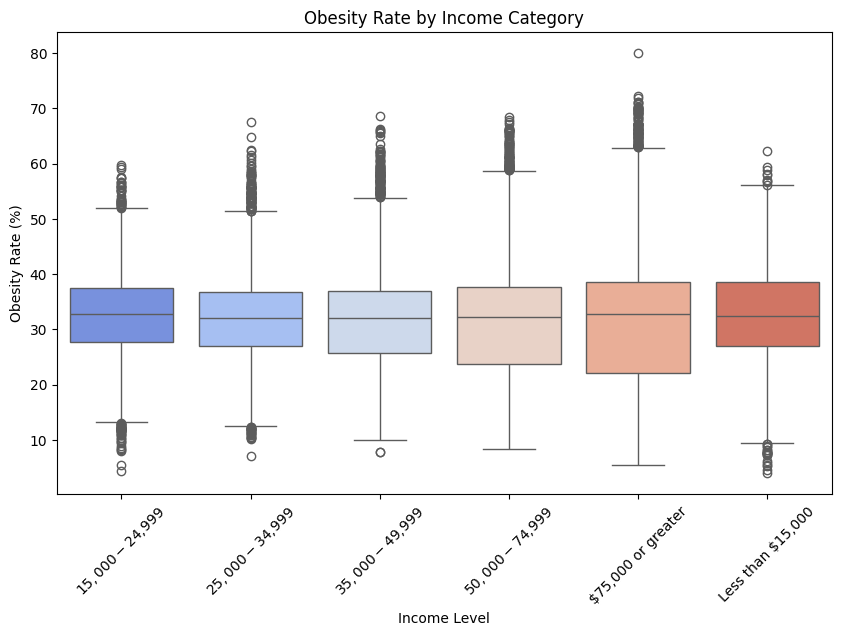

In [24]:
# Plotting the data
plt.figure(figsize=(10,6))
sns.boxplot(data=df_income_clean, x='Income', y='Data_Value', hue='Income', palette='coolwarm', legend=False)
plt.xticks(rotation=45)
plt.title('Obesity Rate by Income Category')
plt.xlabel('Income Level')
plt.ylabel('Obesity Rate (%)')
plt.show()

## Test 3 Conclusion
#### Overall, the plot supports a negative association between income and obesity — individuals in lower income brackets tend to have higher obesity rates, while those in higher income groups tend to have lower rates.
#### This visualization aligns with our ANOVA and Tukey HSD findings, which showed significant differences between the lowest and highest income categories but not among the middle ranges.

# Algorithm Design, Development, and Training

#### Here, we will design and develop our ML model. For this dataset, we will be creating a classifier to predict if an adult is likely to be overweight or not based on lifestyle factors such as exercise frequency and intensity. We will be using the K-Nearest Neighbors (KNN) algorithm as the underlying model in this classifier.

#### We chose to rely on length/frequency and intensity of exercise as the primary basis of our ML classifier because lifestyle factors, such as physical activity, represent the most critical inputs for public health intervention. While demographic factors like income or sex (analyzed during EDA) provide some context, they are static attributes that cannot or are difficult to be directly changed. A classifier built on exercise frequency and intensity offers tangible predictive insights, both by ignoring unavoidable factors such as income and sex, and by aiding healthcare officials and professions in developing preventative campaigns and encouraging behavioral change.

#### Let's start by cleaning up the dataset to prepare for testing:

In [25]:
# keeping only the relevant columns for training
df = df[["YearStart", "LocationAbbr", "LocationDesc", "Class", "Topic", "Question",
         "Data_Value", "Age(years)", "Education", "Sex", "Income", "Race/Ethnicity"]]

# clean up the data value column to ensure consistency in training
df.dropna(subset=["Data_Value"])
df["Data_Value"] = df["Data_Value"].astype(float)

#### Next, we will adjust the dataset so that each group is in it's own row and each question is in its own column, making it easier for classification. We will also prepare the target variable for classification:

#### Some of the key questions from the dataset we took note of are:

*  #### Adults aged 18 and older with **overweight or obese** classifications.
*  #### Adults who achieve **at least 150 minutes a week** of moderate-intensity aerobic physical activity or **75 minutes a week** of vigorous-intensity aerobic activity.
*  #### Adults who achieve **at least 150 minutes a week** of moderate-intensity aerobic physical activity or **75 minutes a week** of vigorous-intensity aerobic activity AND muscle strengthening on **2 or more days a week**.
*  #### Adults who achieve **more than 300 minutes a week** of moderate-intensity aerobic physical activity or **150 minutes a week** of vigorous-intensity aerobic activity.
*  #### Adults who engage in muscle-strengthening activities on **2 or more days a week**.
*  #### Adults who engage in **no** leisure-time physical activity.



In [26]:
# make a new pivot df
new_df = df.pivot_table(
    index=["YearStart", "LocationAbbr"],
    columns = "Question",
    values = "Data_Value",
    aggfunc="mean"
  ).reset_index()

# add a column to classify if percentage is over the obese threshold
new_df["obese"] = (new_df["Percent of adults aged 18 years and older who have obesity"] > 30).astype(int)
new_df

Question,YearStart,LocationAbbr,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults aged 18 years and older who have obesity,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity (or an equivalent combination) and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve more than 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,Percent of adults who report consuming fruit less than one time daily,Percent of adults who report consuming vegetables less than one time daily,obese
0,2011,AK,38.000000,28.064000,56.600000,24.048000,36.784000,32.724000,23.912000,NaN,NaN,0
1,2011,AL,34.212000,31.940000,42.276000,15.352000,24.128000,25.244000,32.704000,NaN,NaN,1
2,2011,AR,34.136000,29.940000,46.116667,17.266667,28.191667,25.016000,30.632000,NaN,NaN,0
3,2011,AZ,37.280769,25.292308,52.500000,24.661538,33.265385,33.219231,24.480769,NaN,NaN,0
4,2011,CA,35.396296,24.451852,58.140741,24.196296,36.466667,32.755556,19.551852,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
692,2023,VT,33.652000,29.508000,63.636000,32.188000,45.376000,40.946154,22.523077,NaN,NaN,0
693,2023,WA,34.685714,32.432143,63.546429,30.671429,43.782143,40.621429,20.842857,NaN,NaN,1
694,2023,WI,33.542308,36.253846,54.392308,26.511538,36.950000,39.526923,29.515385,NaN,NaN,1
695,2023,WV,31.652174,40.982609,51.956522,20.795652,36.577273,31.479167,32.337500,NaN,NaN,1


#### Before we split, we will normalize the data so that the model is trained on features with a consistent scale. We will be using the standard scaler:

In [27]:
# initialize X and Y
feature_cols = new_df.columns[2:-1]
X = new_df[feature_cols]
Y = new_df["obese"]

# impute any missing data
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Now that the data is all ready lets use **train_test_split** on the data:

In [28]:
# split the data
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=42)

#### Finally, we will apply the KNN algorithm to the data:

In [29]:
# creating the classifer
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier()

####Now, we can use a visualization to see how the value of K in KNN affects and shows the tradeoff between overfitting and underfitting.

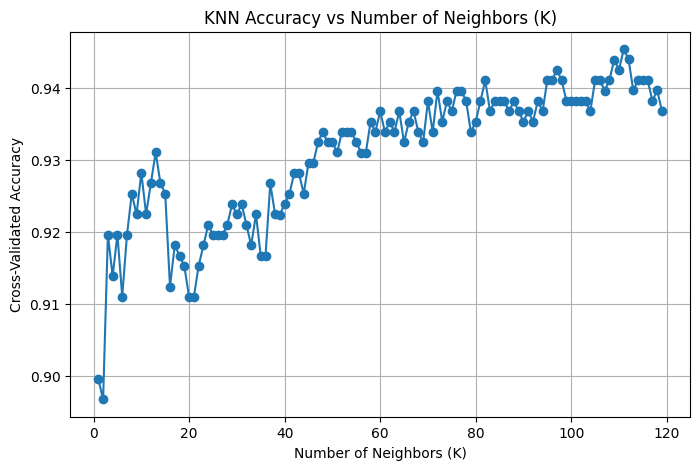

In [30]:
k_values = range(1, 120)
k_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, Y, cv=5, scoring='accuracy').mean()
    k_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_values, k_scores, marker='o')
plt.title("KNN Accuracy vs Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.show()

####The model achieved its best performance around K = 110. Lower values of K produced poor accuracy, likely due to sensitivity to outliers and local noise, which is an indication of underfitting. As K increased past the optimal point, accuracy declined as the model became overly generalized, causing meaningful distinctions between classes to be smoothed out. Hence, selecting an appropriate K value is crucial to balancing model accuracy.

#### Next, we model performance (training vs cross-validation accuracy) changes as the number of training samples increases, revealing whether the model is overfitting, underfitting, or limited by data.

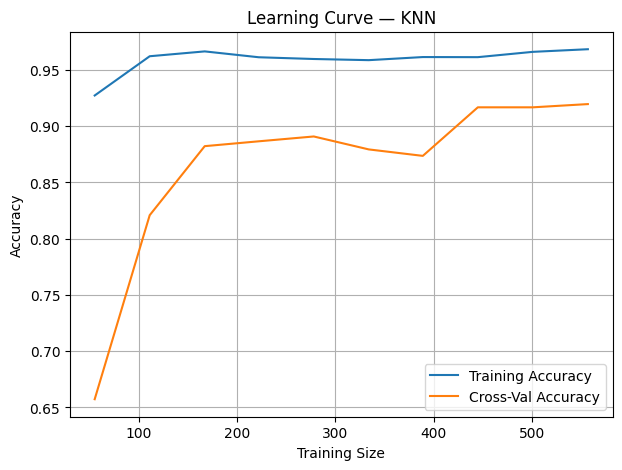

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    KNeighborsClassifier(), X, Y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_scores_mean, label="Training Accuracy")
plt.plot(train_sizes, test_scores_mean, label="Cross-Val Accuracy")
plt.title("Learning Curve — KNN")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

####The learning curve indicates that the KNN classifier improves substantially as more training samples are introduced, with cross-validation accuracy increasing from approximately 0.66 to 0.89 within the first 175 training examples. Beyond this point, performance continues to improve more gradually, eventually stabilizing near 0.92. The training accuracy remains high (0.92–0.96), which suggests mild overfitting, but the relatively small gap between training and validation accuracy indicates that the model generalizes reasonably well. The small decline in validation accuracy around 390 samples is likely due to variability across folds rather than decrease in performance. Overall, the model benefits from additional data until the training size exceeds roughly 450 samples.

#### Before moving into the analysis of our results, we will evaluate the classifier using a receiver operating characteristic (ROC) curve, which visualizes the trade-off between the true positive rate and false positive rate at varying thresholds.

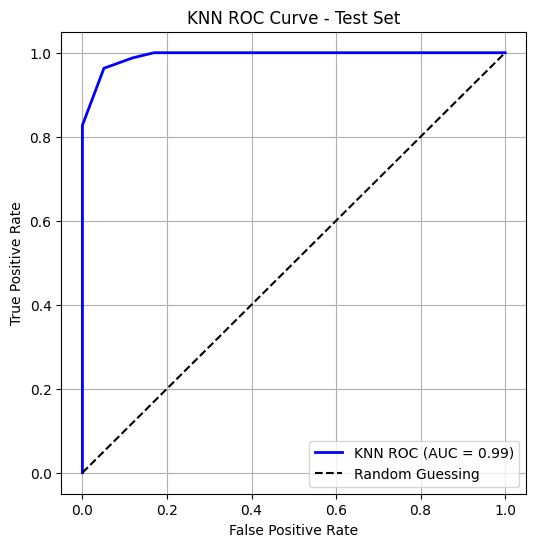

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
# Get predicted probabilities for the positive class
y_score = knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(Y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='b', lw=2, label=f"KNN ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### The model achieved an area under the ROC curve (AUC) of 0.99, indicating that it is highly effective at distinguishing between adults who are likely to be overweight and those who are not. These initial metrics demonstrate strong performance from our KNN model, which we will examine further in the following section.

# Test Data Analysis and Visualization

#### Now that our model is fully trained, how do we ensure that it is actually working as intended? This is where model testing comes in! We will be performing three tests: a confusion matrix, classification report, and k-fold cross validation. These three tests will give us a better picture of the model's performance.

#### We can start by applying a confusion matrix:

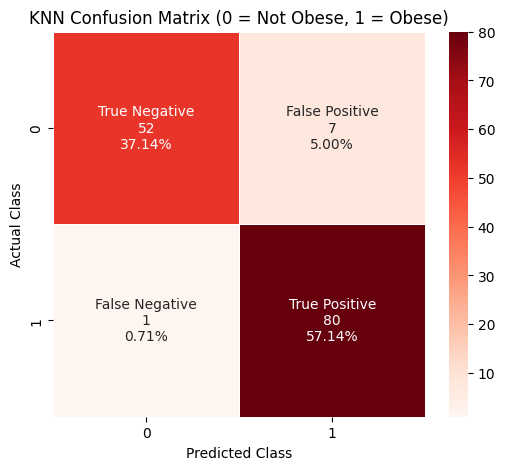

In [40]:
# creating the matrix
Y_pred = knn.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# visualizing confusion matrix
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Reds', linewidths=0.5)

plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("KNN Confusion Matrix (0 = Not Obese, 1 = Obese)")
plt.show()

#### Here's a breakdown of this confusion matrix:

#### True Negatives (Top Left): 52, this means that the model correctly predicted 52 adults as Not Obese. (Actual Not Obese → Predicted Not Obese).

#### True Positives (Bottom Right): 80, this means that the model correctly predicted 80 adults as Obese. (Actual Obese → Predicted Obese).

#### False Positives (Top Right): 7, this means that the model incorrectly predicted 7 adults as Obese, when they were actually Not Obese. This is also called a Type I Error, and are false alarms.

#### False Negatives (Bottom Left): 1, this means that the model incorrectly predicted 1 adult as Not Obese, when they were actually Obese. This is also called a Type II Error, and are missed cases.

#### With these numbers, we can calculate how accurate our model is overall. We know that the model made 140 predictions total (52 + 80 + 7 + 1), and out of those, 132 (52 + 80) were correct identifications of obese or not obese cases.

#### Thus we get:

#### Overall Accuracy ${= \frac{(53+80)}{140}≈0.9429}$

#### These results indicate that the model is performing very well overall, correctly classifying the majority of obese and non-obese individuals with minimal incorrect predictions.

#### From the confusion matrix, our model is 94% accurate overall, which means we are off to a great start!! Next, we will examine our model further with a classification report, which shows us how well the model performs for each class (obese/not obese) independently.

In [41]:
report = classification_report(Y_test, Y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# round numeric values
report_df[["precision", "recall", "f1-score"]] = report_df[["precision",
                                                            "recall",
                                                            "f1-score"]].round(2)

# fix support column
if "support" in report_df.columns:
    report_df["support"] = report_df["support"].fillna(0).astype(int)

report_df

,precision,recall,f1-score,support
0,0.98,0.88,0.93,59
1,0.92,0.99,0.95,81
accuracy,0.94,0.94,0.94,0
macro avg,0.95,0.93,0.94,140
weighted avg,0.95,0.94,0.94,140


#### Recall that we labeled "Not Obese" as **0** and "Obese" as **1**.

#### Looking at the precision scores, we can see that our model has:

*   0.98 for "Not Obese"
*   0.92 for "Obese"

#### This means that when the model predicts a person is not obese, it's correct 98% of the time. When it predicts obese, it's correct 92% of the time.

#### Now looking at the recall scores, we can see that our model has:

*   0.88 for "Not Obese"
*   0.99 for "Obese"

#### This means that of all the people who actually are not obese, the model correctly identified 88% of them, and of all the people who actually are obese, the model correctly identified 99%.

#### The F1-score, which is a combined metric including both precision and recall, is also high at 0.93 for "Not Obese" and 0.95 for "Obese".

#### Overall, our model is performing strongly for both classes, and has nearly perfect recall (99%) for the "Obese" class, meaning it almost never misses an obese adult. This is a fantastic result for a health classifier, and is one of the strong points of the model we can identify from our analysis!

#### The following visualization provides a graphical interpretation of these results:

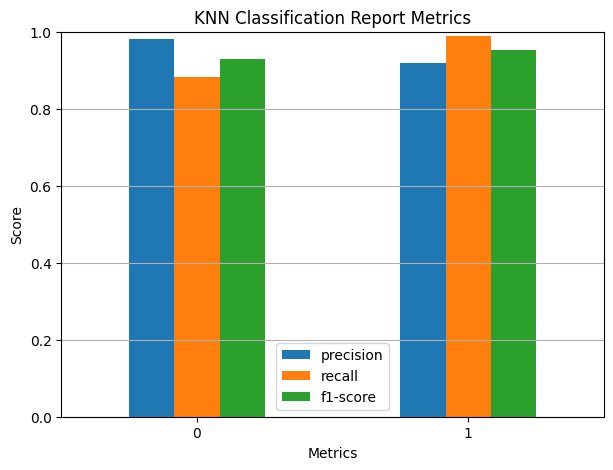

In [42]:
# Convert classification report to DataFrame
report_dict = classification_report(Y_test, Y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.iloc[:2, :3]

report_df.plot(kind='bar', figsize=(7,5))
plt.xlabel("Metrics")
plt.title("KNN Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

 #### Now that we've ascertained our model's accuracy, we must ensure that it retains this accuracy in all scenarios. Our current evaluation is based on a single 80/20 train/test split, and we need to make sure that this good performance wasn't due to a lucky train/test split.

 #### We can now run a K-Fold Cross-Validation test to validate the stability of our model. We will be splitting the data into 5 folds, meaning that at any given time, the data will be trained on four folds and tested on the fifth. This runs five times so that each fold will be a test fold, meaning we will have five cross-validation scores.

In [43]:
# creating the folds for the algorithm
k_folds = KFold(n_splits = 5)

# finding the cross-valdiation score
scores = cross_val_score(knn, X, Y, cv=k_folds, scoring='accuracy')

#### Now we will visualize how the data was split across each fold:

In [44]:
keep = [[train_idx, test_idx, scores[i]] for i, (train_idx, test_idx) in enumerate(k_folds.split(X, Y))]

def create_df(fold_data):
    train_df = pd.DataFrame({'index': fold_data[0], 'group': 'train', 'score': fold_data[2]})
    test_df = pd.DataFrame({'index': fold_data[1], 'group': 'test', 'score': fold_data[2]})
    return pd.concat([train_df, test_df])

df_cv = pd.concat([create_df(fold) for fold in keep]).reset_index(drop=True)
df_cv['CV iteration'] = [i+1 for i, fold in enumerate(keep) for _ in range(len(fold[0]) + len(fold[1]))]

# Interactive Plotly scatter
fig = px.scatter(df_cv, x='index', y='CV iteration', color='group',
                 color_discrete_map={'train':'blue','test':'red'},
                 hover_data={'score': True},
                 title='KNN K-Fold CV — Train/Test Split')

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(
    yaxis_title='CV Fold',
    xaxis_title='Sample Index',
    yaxis=dict(
        tickmode='array',
        tickvals=[1, 2, 3, 4, 5]
    )
)
fig.show()

#### We can see that rouhgly 20% of each fold is used for testing while the rest is used for training. This means that all of our dataset will be used for testing and training at some point.

#### Next we want to see how well each fold performs. We will do so by finding the accuracy scores:

In [45]:
cv_results = {
    "Fold": [1, 2, 3, 4, 5, "Average", "Std Deviation"],
    "Accuracy Score": [
        scores[0],
        scores[1],
        scores[2],
        scores[3],
        scores[4],
        scores.mean(),
        statistics.stdev(scores)
    ]
}

cv_df = pd.DataFrame(cv_results)
cv_df["Accuracy Score"] = cv_df["Accuracy Score"].round(4)

# used HTML library because .style.hide() was being weird
HTML(cv_df.to_html(index=False))

Fold,Accuracy Score
1,0.9357
2,0.9000
3,0.9353
4,0.9424
5,0.8993
Average,0.9225
Std Deviation,0.0211


#### Below is a visualization of the accuracy scores:

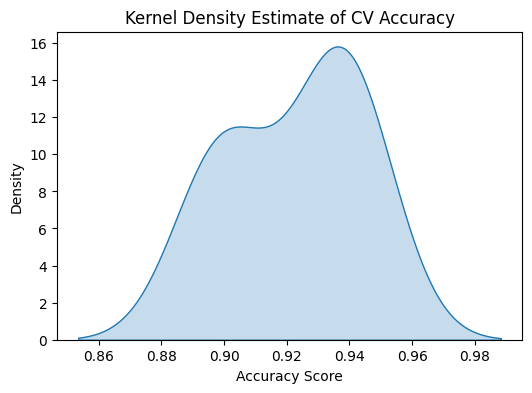

In [46]:
plt.figure(figsize=(6,4))
sns.kdeplot(scores, fill=True)

plt.title("Kernel Density Estimate of CV Accuracy")
plt.xlabel("Accuracy Score")
plt.show()

#### We can see from the table that individual cross validation scores are 93.57%, 90.00%, 93.53%, 94.24%, and 89.93%. With a mean score of 92.25% and a standard deviation of just 2.11%. Our graph shows us that there is a local maximum at around 90%, with a true maximum at around 94%. Either way, there is insignificant variation among the results, indicating that our model is not sensitive to noise or specific data points within the dataset. This is excellent! Not only is our model accurate, it's accurate across different subsets of the data and likely to be highly generalizable based on our testing results.

# Result Analysis and Conclusion
####Based on our findings, we are successfully able to point out some of the key factors contributing to adult obesity prevalence.

####1.   Socioeconomic Disparity: It became obvious that there is a strong inverse relationship between income and obesity. The ANOVA and Tukey HSD analyses show that the lowest income category (less than or equal to \$15,000) has significantly higher mean obesity rates than the highest income category (greater than or equal to \$75,000), providing evidence of socioeconomic health disparities.
####2.   Modifiable Risk Prediction: The KNN classifier shows that modifiable lifestyle factors like physical activity are highly predictive of regional obesity rates, with a mean cross-validation accuracy of 92.25% and a standard deviation of only 2.11%.
####3.   High Accuracy: A major strength of our model is its 99% recall for the "Obese" class. This level of accuracy allows for actionable insights, enabling  public health officials to proactively identify regions nearing or exceeding the 30% obesity threshold and intervene before the public health crisis escalates.
####4.   Lack of Disparity Related to Sex: We found no statistically significant difference in mean obesity rates related to males and females, suggesting that while income-based campaigns may be valuable to target obesity rate, sex-based campaigns would likely have no use.


## Pathways For Intervention


####1.   Targeted Outreach: Public health efforts should be explicitly tailored to address the socioeconomic barriers experienced by lower income populations to improve access to healthy foods and safe physical activity options.
####2.   Early Warning System: Our KNN model can be deployed and used as an early warning system, using current data on regional physical activity metrics to predict future obesity rates. This will allow for officials to take a shift from a reactive to a proactive approach in public health policy, prioritizing regions that are lagging behind and are at heightened risk of high obesity prevalence.